In [1]:
# Needed to reload modified modules
%load_ext autoreload
%autoreload 2

In [2]:
# Inspect the input data
import time
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from utils import minmax_normalize_param, unnormalize_params, real_files_to_tensors

from models import EncoderDecoderModel

# some initializations
data_dir = './tomo_data/REAL_DATA_Run2_2'

IMG_OUTPUT_SIZE = 128
latent_dim = 7  # 6 + the new VrfSPS

zeropad = 14
start_turn = 1
skipturns = 3
Ib = 1.16e11

normalization = 'minmax'
img_normalize = 'off'
ps_normalize = 'off'

E_normFactor = 25000000000.0
B_normFactor = 800000000.0
T_normFactor = 28000000000.0

var_names = ['phEr', 'enEr', 'bl','inten', 'Vrf', 'mu', 'VrfSPS']
loss_weights = [0, 1, 2, 3, 4, 5, 6]

# enc_timestamp = get_best_model_timestamp('./trials', model='enc')
enc_timestamp = 'best_encoder_TF'
dec_timestamp = 'best_decoder_TF'


2024-01-25 09:42:15.075166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 09:42:22.097304: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 09:42:24.772406: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2024-01-25 09:42:24

In [3]:

wf_test_orig, wf_id, bunch_profiles_orig = real_files_to_tensors(data_dir,
                                                                 Ib=Ib,
                                                                 T_normFactor=T_normFactor,
                                                                 corrTriggerOffset=False)
print(wf_test_orig.shape)
print(bunch_profiles_orig.shape)
print('Max value in wf: ', np.max(wf_test_orig))
print('Min value in wf: ', np.min(wf_test_orig))

# Correct the input data
wf_test, _, bunch_profiles = real_files_to_tensors(data_dir,
                                                   Ib=Ib,
                                                   T_normFactor=T_normFactor,
                                                   corrTriggerOffset=True)



(48, 128, 128, 1)
(48, 128, 326, 1)
Max value in wf:  0.16974305
Min value in wf:  -0.0049708607


2023-09-04 17:22:20.820899: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-09-04 17:22:20.834052: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-09-04 17:22:20.834117: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2023-09-04 17:22:21.061724: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

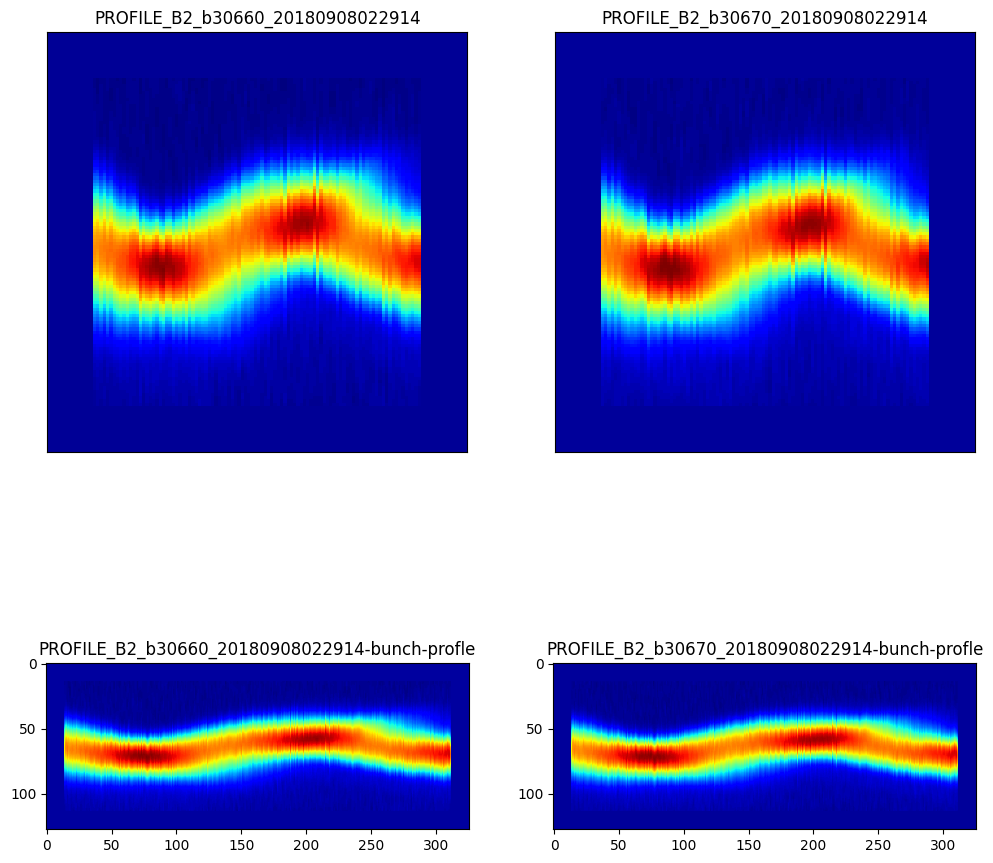

In [4]:
%matplotlib inline
# plot some of the outputs

nrows = 2
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(wf_test_orig)),
                          size=nrows, replace=False)

samples_X = tf.gather(wf_test_orig, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
for i in range(len(sample)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(samples_X[i], cmap='jet')
    # Set the label
    # title = ','.join([f'{num:.1f}' for num in sample[i]])
    ax.set_title(f'{wf_id[i]}')

    ax = axes[i+2]
    # show the image
    ax.imshow(bunch_profiles_orig[sample[i]], cmap='jet')
    ax.set_title(f'{wf_id[i]}-bunch-profle')


2024-01-25 09:47:01.935787: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2024-01-25 09:47:01.947930: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2024-01-25 09:47:01.947974: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2024-01-25 09:47:02.132089: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

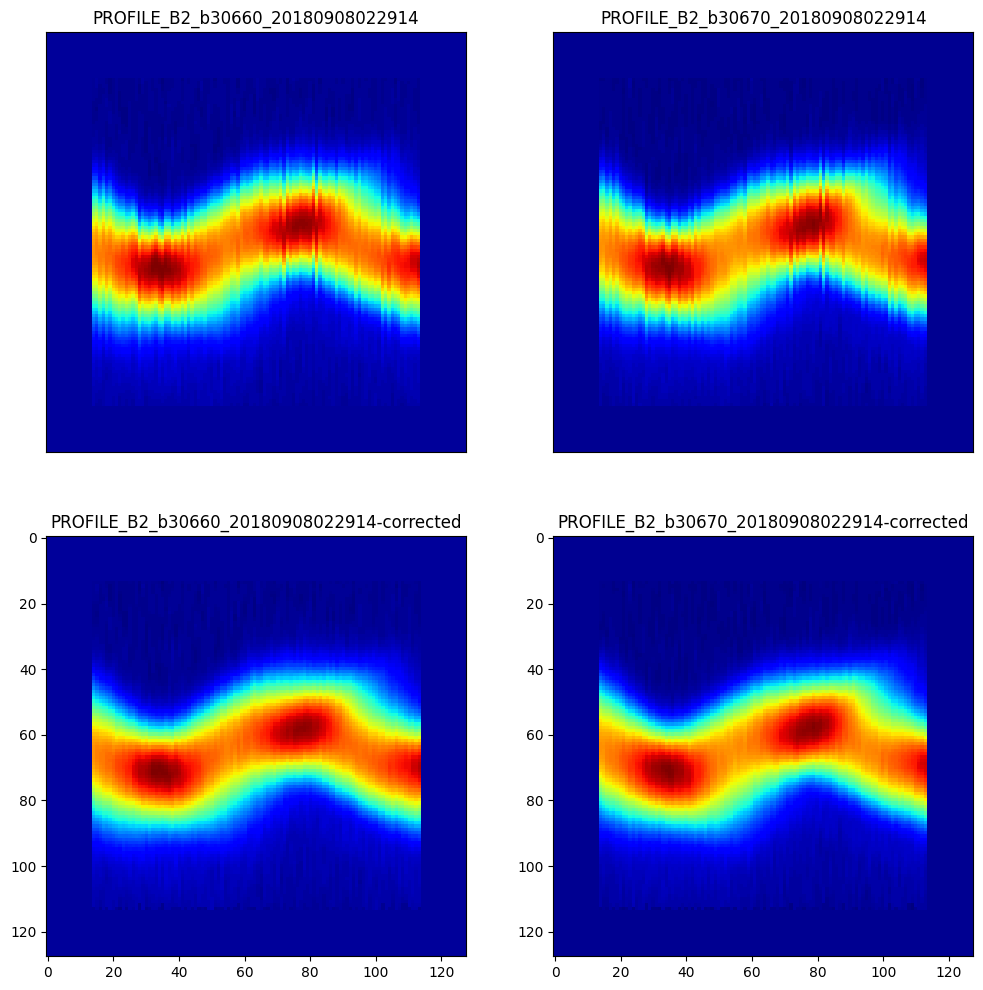

In [4]:


nrows = 2
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(wf_test_orig)),
                          size=nrows, replace=False)

samples_X = tf.gather(wf_test_orig, sample)
samples_X_corrected = tf.gather(wf_test, sample)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=nrows, nrows=nrows, figsize=(12, 12))
axes = np.ravel(axes)
# for i in range(len(axes)):
for i in range(len(sample)):
    ax = axes[i]
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(samples_X[i], cmap='jet')
    ax.set_title(f'{wf_id[i]}')

    ax = axes[i+2]
    # show the image
    ax.imshow(samples_X_corrected[i], cmap='jet')
    ax.set_title(f'{wf_id[i]}-corrected')


## Testing the models on the real data

In [5]:
# Load the model
print('Encoder: ', enc_timestamp)

# Initialize directories
enc_trial_dir = os.path.join('./trials/', enc_timestamp)
enc_weights_dir = os.path.join(enc_trial_dir, 'weights')
assert os.path.exists(enc_weights_dir)

print('Decoder: ', dec_timestamp)

# Initialize directories
dec_trial_dir = os.path.join('./trials/', dec_timestamp)
dec_weights_dir = os.path.join(dec_trial_dir, 'weights')
assert os.path.exists(dec_weights_dir)

# initialize directory to save the plots
timestamp = f'enc_{enc_timestamp}_dec_{dec_timestamp}'
print('Timestamp: ', timestamp)
plots_dir = os.path.join('./plots', 'end_to_end', timestamp)
os.makedirs(plots_dir, exist_ok=True)

encDec = EncoderDecoderModel()
encDec.load(enc_weights_dir=enc_weights_dir, dec_weights_dir=dec_weights_dir)

# for model in (encDec.encoder.model):
#     print(model.summary())


Encoder:  best_encoder_TF
Decoder:  best_decoder_TF
Timestamp:  enc_best_encoder_TF_dec_best_decoder_TF


In [6]:
tf.keras.utils.plot_model(encDec.decoder.model, show_shapes=True, dpi=100,
                          to_file=f'{dec_trial_dir}/model-layout.png',
                          show_layer_activations=True, expand_nested=True)

print(encDec.decoder.model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense_1 (Dense)             (None, 256)               2304      
                                                                 
 Dense_2 (Dense)             (None, 1024)              263168    
                                                                 
 Expand (Dense)              (None, 8192)              8396800   
                                                                 
 Reshape (Reshape)           (None, 16, 16, 32)        0         
                                                                 
 CNN_1 (Conv2DTranspose)     (None, 32, 32, 32)        82976     
                                                                 
 CNN_2 (Conv2DTranspose)     (None, 64, 64, 16)        41488     
                                                                 
 CNN_3 (Conv2DTranspose)     (None, 128, 128, 8)      

In [7]:
import visualkeras

visualkeras.layered_view(encDec.decoder.model, to_file=os.path.join(dec_trial_dir, 'decoder-visual.png'), 
                         legend=True, index_ignore=[], max_z=100, max_xy=400, draw_volume=False).show()

In [8]:
import visualkeras

for model in (encDec.encoder.model):
    # print(model.output_name)
    # tf.keras.utils.plot_model(model.model, show_shapes=True, dpi=100,
    #                       to_file=f'{enc_trial_dir}/{model.output_name}-model-layout.png',
    #                       show_layer_activations=True, expand_nested=True)
    visualkeras.layered_view(model.model, to_file=f'{enc_trial_dir}/{model.output_name}-model-visual.png', 
                         legend=True, index_ignore=[], max_z=100, max_xy=400, draw_volume=False)
    # print(model.model.summary())


In [9]:
# normalize the turns
# select a number of turns (31)
selected_turns = np.linspace(1, 298, num=298, endpoint=True, dtype=np.float32)
print(selected_turns)
norm_turns = minmax_normalize_param(selected_turns, np.min(selected_turns),
                                    np.max(selected_turns),
                                    target_range=(0, 1))


[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117. 118. 119. 120. 121. 122. 123. 124. 125. 126.
 127. 128. 129. 130. 131. 132. 133. 134. 135. 136. 137. 138. 139. 140.
 141. 142. 143. 144. 145. 146. 147. 148. 149. 150. 151. 152. 153. 154.
 155. 156. 157. 158. 159. 160. 161. 162. 163. 164. 165. 166. 167. 168.
 169. 170. 171. 172. 173. 174. 175. 176. 177. 178. 179. 180. 181. 182.
 183. 184. 185. 186. 187. 188. 189. 190. 191. 192. 193. 194. 195. 196.
 197. 

In [12]:
from utils import minMaxScaleIMG
def assess_model_real_data(wf, wf_id, bunch_profile, latent_pred, 
                           ps_pred, turn, figname, savefig=False):
    '''
    Visual end-to-end evaluation. 
    Left: Waterfall (input)
    Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
    Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
    '''
    fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(12, 5),
                            gridspec_kw={'width_ratios': [5, 4, 5]})

    wf_s = np.array(wf).reshape(128, 128).T
    # wf_s = wf_s[zeropad:-zeropad, zeropad:-zeropad]
    latent_pred = latent_pred.numpy().reshape((1, -1))

    latent_pred_unnorm = unnormalize_params(
        latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
        latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5],
        latent_pred[:, 6], normalization=normalization)
    
    # print(latent_pred_unnorm.shape)
    # # start with top left plot, the waterfall
    plt.sca(axes[0])
    plt.imshow(wf_s, cmap='jet')
    plt.title(f'{wf_id}', fontsize=12)
    # plt.xticks([], []); plt.yticks([], [])

    # top right plot
    plt.sca(axes[1])
    # plt.gca().set_facecolor('xkcd:light grey')
    plt.axis('off')
    rowLabels = [var_names[w] for w in loss_weights]
    # cellText = [[latent] for latent in latent_pred_unnorm]
    plt.table(cellText=latent_pred_unnorm, rowLabels=rowLabels,
        colLabels=['Value'], loc='center')

    # bottome right plot 
    plt.sca(axes[2])
    plt.title(f'Time Projection, Turn: {turn}', fontsize=14)
    time_profile_pred = minMaxScaleIMG(np.sum(ps_pred[:, :, 0], 0))

    # Which turn? 
    target_turn = int(minmax_normalize_param(turn, 1, 298, target_range=(zeropad, wf.shape[1] - zeropad-1)))
    bunch_profile_turn = int(minmax_normalize_param(turn, 1, 298, target_range=(zeropad, bunch_profile.shape[1]- zeropad-1)))

    # wf_turn = zeropad + int((IMG_OUTPUT_SIZE - 2 * zeropad-1) * turn/298)
    # print(turn, wf_turn)
    time_profile_target = minMaxScaleIMG(wf_s[target_turn, :])
    bunch_profile_target = minMaxScaleIMG(bunch_profile[:, bunch_profile_turn])
    
    plt.plot(time_profile_pred, label='Prediction')
    # plt.plot(time_profile_target, label='Target 100 trn', marker='')
    plt.plot(bunch_profile_target, label='Target 300 trn', marker='')

    # plt.plot(np.sum(wf_s[:, :], 1), label='Target, axis=1')
    plt.legend(fontsize=14, loc='center left')
    # plt.xticks([], []); plt.yticks([], [])

    plt.tight_layout()
    if savefig:
        plt.savefig(figname, dpi=100, bbox_inches='tight')
    else:
        plt.show()
    plt.close()

In [10]:
from utils import loadTF, calc_bin_centers, bunchProfile_TFconvolve

time_scale=calc_bin_centers(0, 2.5e-9, 100)
tf_path = './tomo_data/transfer_functions/TF_B{}.h5'
freq_array, TF_array = loadTF(path=tf_path)

def assess_model_real_data_no_table(wf, wf_id, bunch_profile, latent_pred, 
                                    ps_pred, turn, figname, savefig=False):
    '''
    Visual end-to-end evaluation. 
    Left: Waterfall (input)
    Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
    Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
    '''
    fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(8, 3),
                             gridspec_kw={'width_ratios': [5, 5]})

    wf_s = np.array(wf).reshape(128, 128).T
    # wf_s = wf_s[zeropad:-zeropad, zeropad:-zeropad]
    latent_pred = latent_pred.numpy().reshape((1, -1))

    latent_pred_unnorm = unnormalize_params(
        latent_pred[:, 0], latent_pred[:, 1], latent_pred[:, 2],
        latent_pred[:, 3], latent_pred[:, 4], latent_pred[:, 5],
        latent_pred[:, 6], normalization=normalization)

    # # start with top left plot, the waterfall
    plt.sca(axes[0])
    plt.imshow(wf_s, cmap='jet')
    plt.title(f'{wf_id.split("PROFILE_")[1]}', fontsize=12)
    plt.xticks([], []); plt.yticks([], [])
    plt.tight_layout()


    # bottome right plot
    plt.sca(axes[1])
    plt.title(f'Time Projection, Turn: {turn}', fontsize=14)
    time_profile_pred = minMaxScaleIMG(np.sum(ps_pred[:, :, 0], 0))
    time_profile_pred = np.reshape(time_profile_pred, (128, 1))
    # time_profile_pred = np.sum(ps_pred[:, :, 0], 0)
    # Convolve with transfer function
    _, time_profile_pred_tf = bunchProfile_TFconvolve(time_profile_pred[14:-14], time_scale,
                                                   freq_array, TF_array)
    # Pad with zeros from 100 -> 128     
    time_profile_pred_tf = np.pad(time_profile_pred_tf[:, 0], 14)

    # Which turn?
    target_turn = int(minmax_normalize_param(
        turn, 1, 298, target_range=(zeropad, wf.shape[1] - zeropad-1)))
    bunch_profile_turn = int(minmax_normalize_param(
        turn, 1, 298, target_range=(zeropad, bunch_profile.shape[1] - zeropad-1)))

    # wf_turn = zeropad + int((IMG_OUTPUT_SIZE - 2 * zeropad-1) * turn/298)
    # print(turn, wf_turn)
    time_profile_target = minMaxScaleIMG(wf_s[target_turn, :])
    bunch_profile_target = minMaxScaleIMG(bunch_profile[:, bunch_profile_turn])
    # bunch_profile_target = (bunch_profile[:, bunch_profile_turn])

    plt.plot(time_profile_pred, label='PRED')
    plt.plot(time_profile_pred_tf, label='PRED \w TF', marker='')

    # plt.plot(time_profile_target, label='TRUE 100 trn', marker='')
    plt.plot(bunch_profile_target, label='TRUE 300 trn', marker='')

    # print(time_profile_pred.shape)
    # print(bunch_profile_target.shape)
    # print(np.abs(time_profile_pred - bunch_profile_target).shape)
    # Also plot the diff
    # plt.plot(np.abs(time_profile_pred - bunch_profile_target), label='DIFF')

    # plt.plot(np.sum(wf_s[:, :], 1), label='Target, axis=1')
    plt.legend(fontsize=14, loc='center left')
    plt.xticks([], []); plt.yticks([], [])

    plt.tight_layout()
    if savefig:
        plt.savefig(figname, dpi=100, bbox_inches='tight')
    else:
        plt.show()
    plt.close()


/afs/cern.ch/work/k/kiliakis/git/tomography_ML/local_utils.py:83: RuntimeWarning: divide by zero encountered in log10
  filt = (20*np.log10(np.abs(TF_array)) < -cut) & (TF_array > 0)


In [ ]:
# Plot the predictions
out_dir = 'plots/real_data_correct_TF'
for norm_turn in norm_turns[:]:
    # expand turns to be equal to the number of test points
    turn_test = np.ones(len(wf_test), dtype=np.float32)*norm_turn
    # get the predictions
    start_t = time.time()
    latent_pred, ps_pred = encDec.predict(wf_test, turn_test)
    duration = time.time() - start_t
    print(f'Time taken for {len(turn_test)} predictions : {duration:.2f}, {duration/len(turn_test):.2f}')
    continue
    # Now I need to plot them
    # one directory per WF
    for i in np.arange(len(wf_test))[:1]:
        unnorm_turn = int(minmax_normalize_param(norm_turn, 0, 1, target_range=(1, 298)))
        # save in a figure the turn, latents, input image, output image
        os.makedirs(out_dir + f'/{wf_id[i]}', exist_ok=True)
        figname = out_dir+ f'/{wf_id[i]}/time_profile_{unnorm_turn:03d}.png'
        assess_model_real_data_no_table(wf_test[i], wf_id[i], bunch_profiles[i],
                        latent_pred[i], ps_pred[i], 
                        unnorm_turn, figname, savefig=False)

        # figname = out_dir+ f'/{wf_id[i]}/latents_time_projection_{unnorm_turn:03d}.png'
        # assess_model_real_data(wf_test[i], wf_id[i], bunch_profiles[i],
        #                 latent_pred[i], ps_pred[i], 
        #                 unnorm_turn, figname, savefig=True)



        

In [19]:
from utils import minMaxScaleIMG
from utils import loadTF, calc_bin_centers, bunchProfile_TFconvolve

time_scale = calc_bin_centers(0, 2.5e-9, 100)
tf_path = './tomo_data/transfer_functions/TF_B{}.h5'
freq_array, TF_array = loadTF(path=tf_path)


def reconstruct_wf(wf, wf_id, bunch_profile, ps_pred, turns, figname, savefig=False, showfig=True):
    '''
    Visual end-to-end evaluation. 
    Left: Waterfall (input)
    Middle: Bar plot with features (latent space), real and predicted. For the evaluation of the encoder. 
    Middle bottom: PS at a given turn, real and predicted. For the evaluation of the decoder. 
    '''
    # fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(9, 3))

    wf_s = minMaxScaleIMG(np.array(wf).reshape(128, 128).T)

    # axis = 0 : the turns (1 ps per turn)
    # axis = 1 : the vertical axis, the time bins
    # axis = 2 : the horizontal axis, the energy bins
    # axis = 3 : dummy axis, shape=1
    wf_pred = np.sum(ps_pred, axis=1)
    # print(wf_pred.shape)
    wf_pred = wf_pred.reshape((100, 128))
    _, wf_pred_tf = bunchProfile_TFconvolve((wf_pred.T)[14:-14], time_scale, freq_array, TF_array)
    wf_pred_tf = minMaxScaleIMG(wf_pred_tf)


    wf_pred = np.pad(wf_pred, ((14, 14), (0, 0)))
    wf_pred_tf = np.pad(wf_pred_tf.T, ((14, 14), (14, 14)))
    # print(wf_pred.shape)
    
    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))

    # # start with left plot, the original waterfall
    plt.sca(axes)
    plt.imshow(wf_s[14:-14, 14:-14], cmap='jet')
    plt.title(f'Measurement, corrected', fontsize=18)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()
    
    if savefig:
        plt.savefig(figname.replace('reconstruction', 'measurement'), dpi=200, bbox_inches='tight', transparent=True)
    if showfig:
        plt.show()
    if savefig or showfig:
        plt.close()

    fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))

    # middle plot, the predicted waterfall, with TF
    plt.sca(axes)
    plt.imshow(wf_pred_tf[14:-14, 14:-14], cmap='jet')
    plt.title(f'Reconstructed Waterfall', fontsize=18)
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tight_layout()

    mae_loss = np.mean(np.abs(wf_s - wf_pred_tf)[14:-14, 14:-14])
    # print('MAE loss s: ', np.mean(np.abs(wf_s - wf_pred_tf)[14:-14, 14:-14]))
    # print('MAE loss: ', np.mean(np.abs(wf - wf_pred_tf)[14:-14, 14:-14]))

    if savefig:
        plt.savefig(figname, dpi=200, bbox_inches='tight', transparent=True)
    if showfig:
        plt.show()
    if savefig or showfig:
        plt.close()

    return mae_loss

    # third plot, the difference waterfall, with TF
    # plt.sca(axes[2])
    # plt.imshow(np.abs(wf_s - wf_pred_tf)[14:-14, 14:-14], cmap='jet')
    # plt.title(f'Diff', fontsize=12)
    # plt.xticks([], [])
    # plt.yticks([], [])
    # plt.tight_layout()
    # plt.delaxes(axes[1])


    # plt.tight_layout()
    # if savefig:
    #     plt.savefig(figname, dpi=200, bbox_inches='tight', transparent=True)
    # else:
    #     plt.show()
    # plt.close()

1/4 [======>.......................] - ETA: 0s

/tmp/ipykernel_25368/1401902589.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(4, 4))


4/4 [==============================] - 0s 31ms/step
Mean MAE loss:  0.02984809695535683


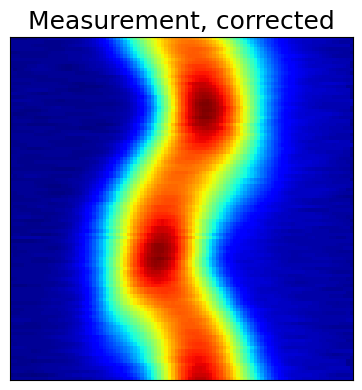

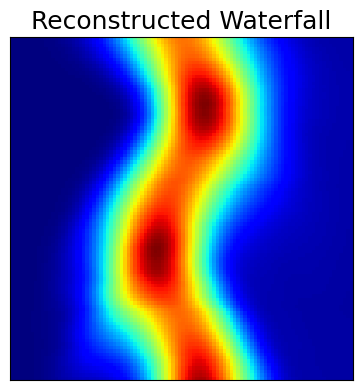

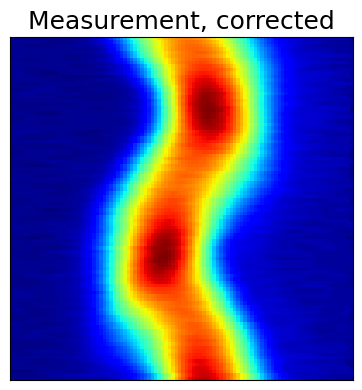

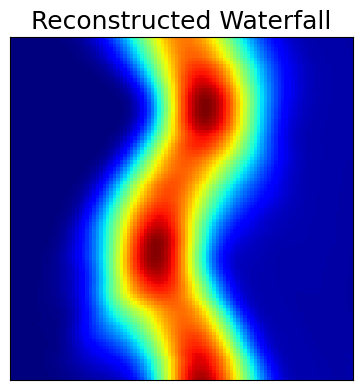

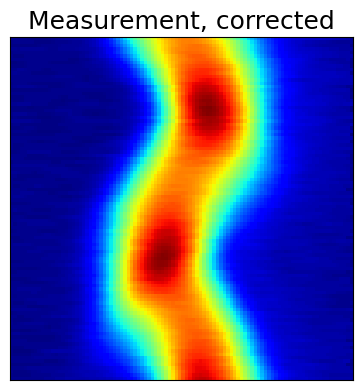

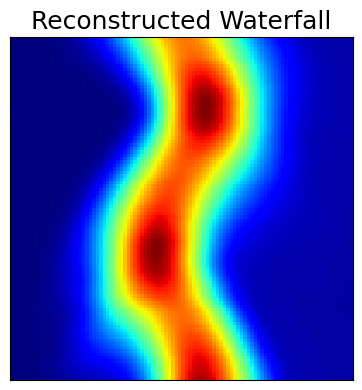

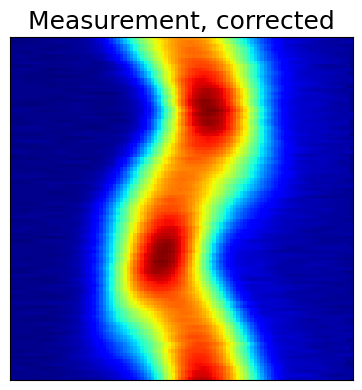

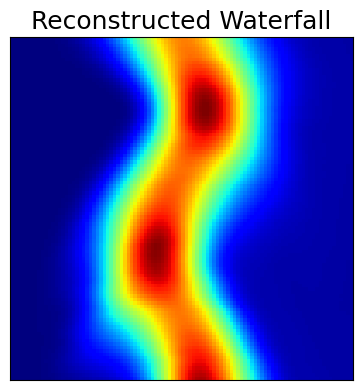

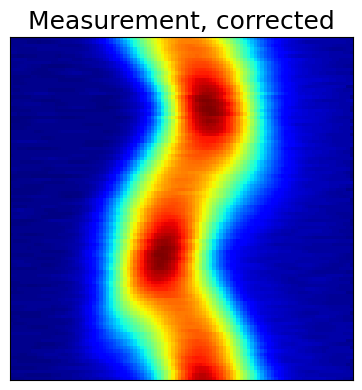

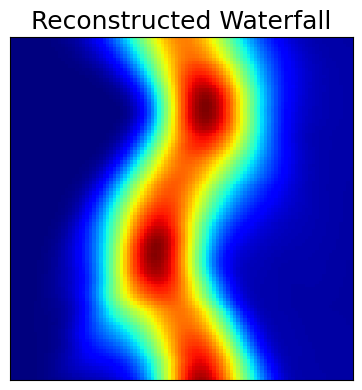

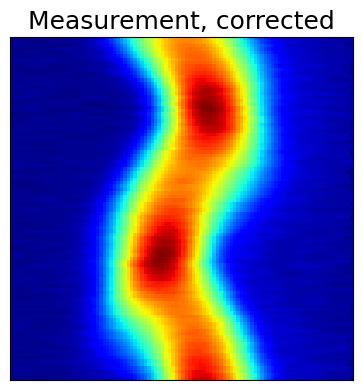

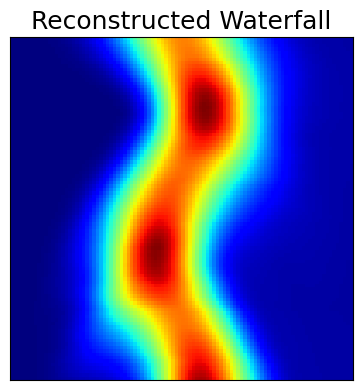

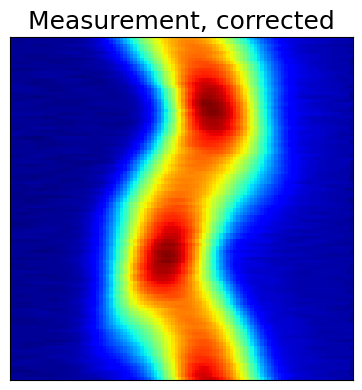

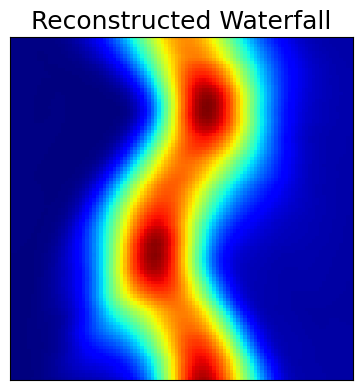

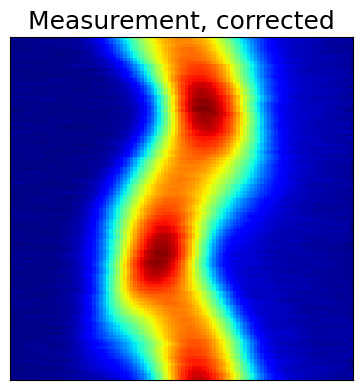

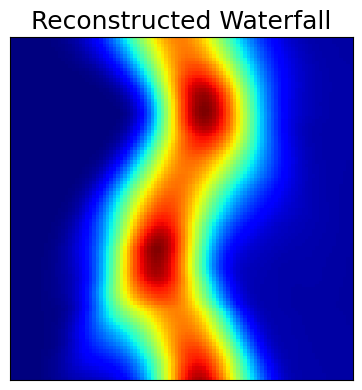

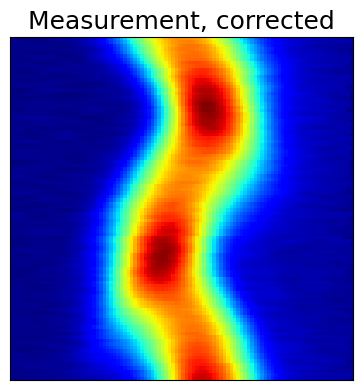

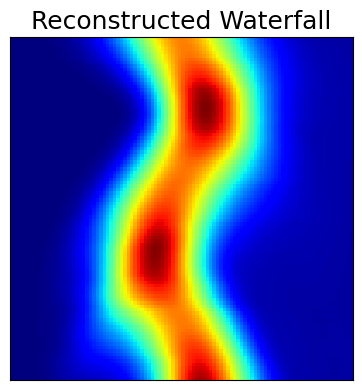

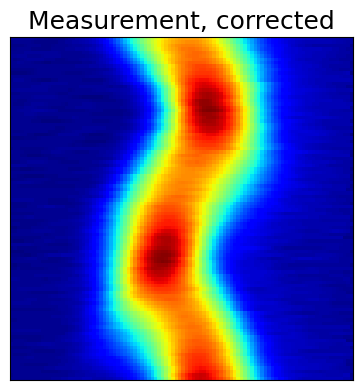

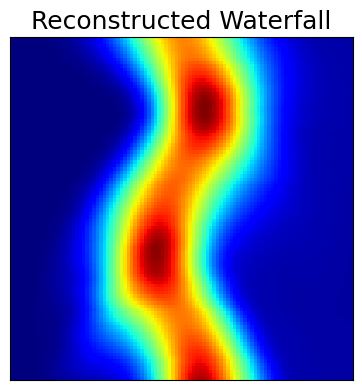

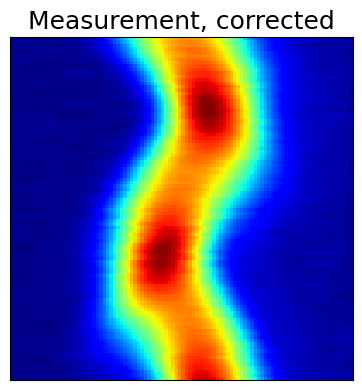

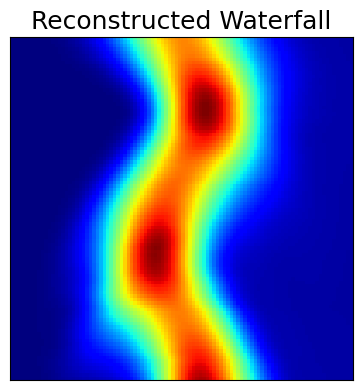

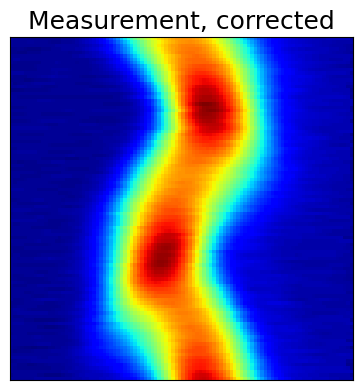

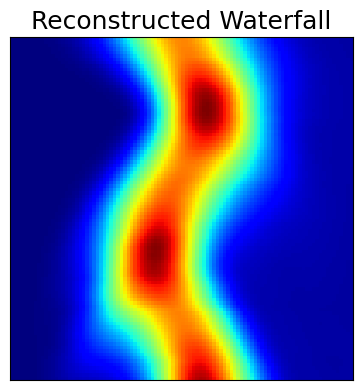

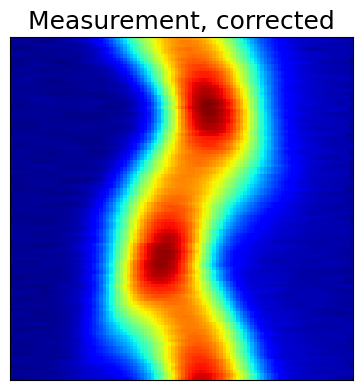

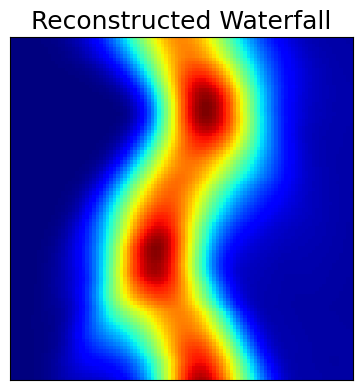

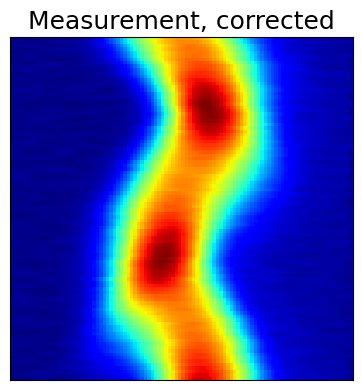

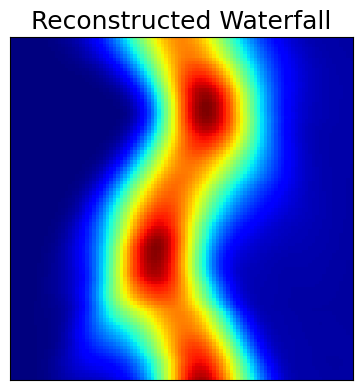

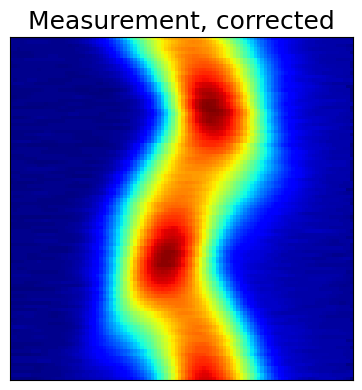

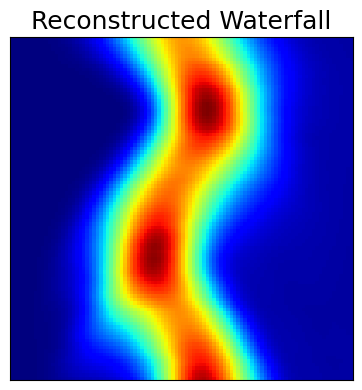

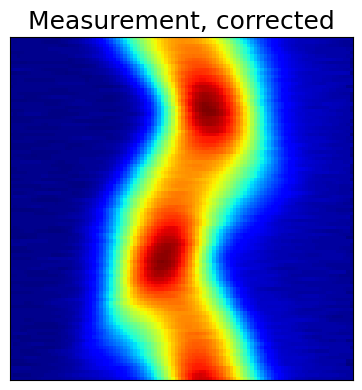

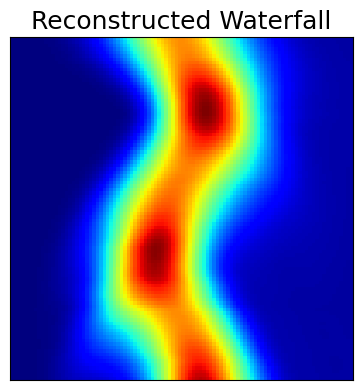

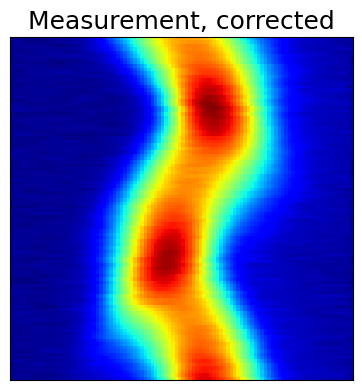

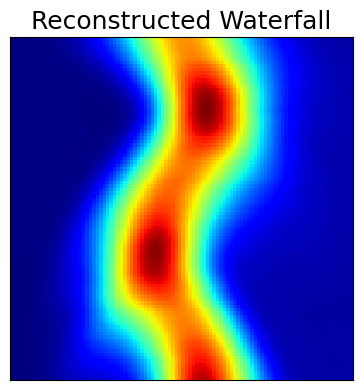

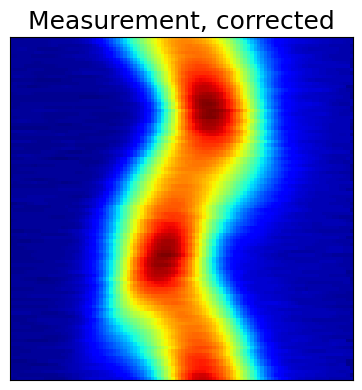

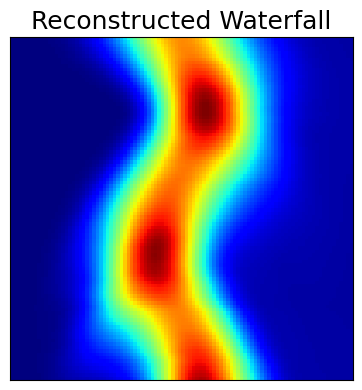

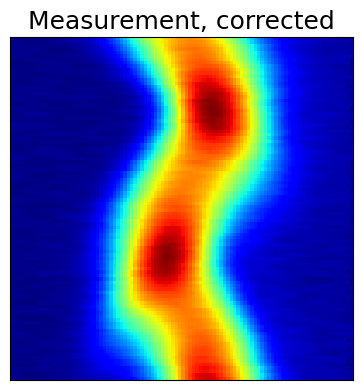

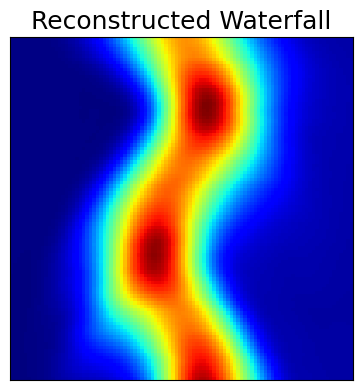

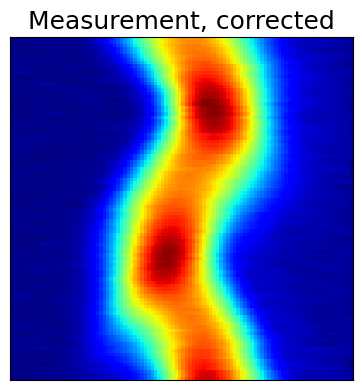

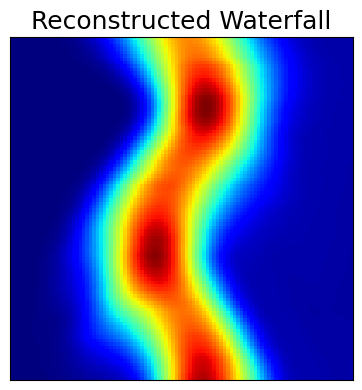

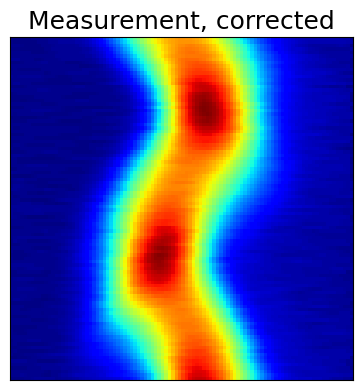

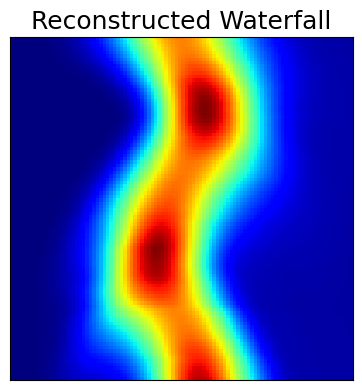

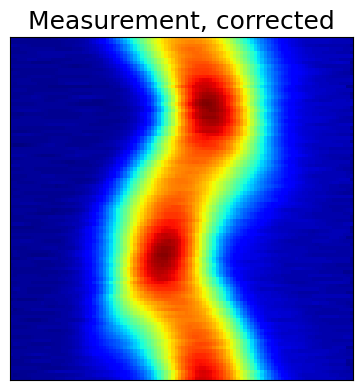

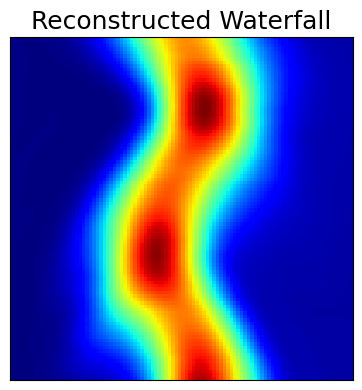

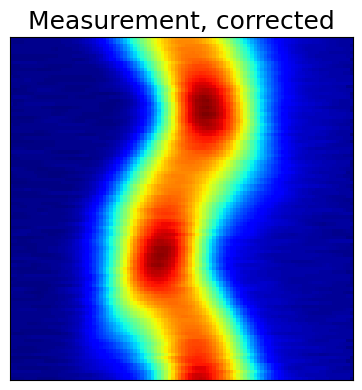

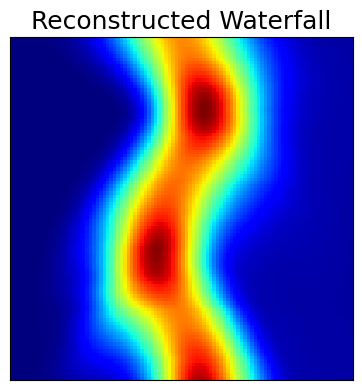

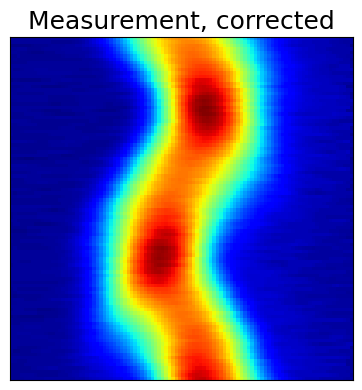

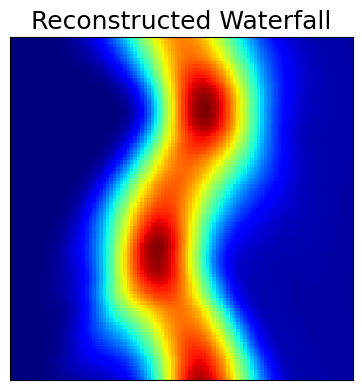

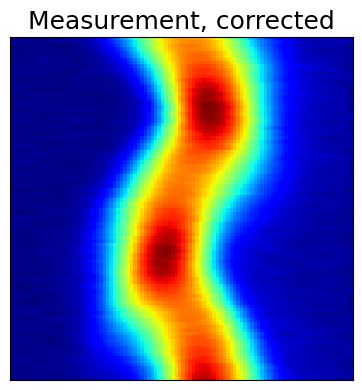

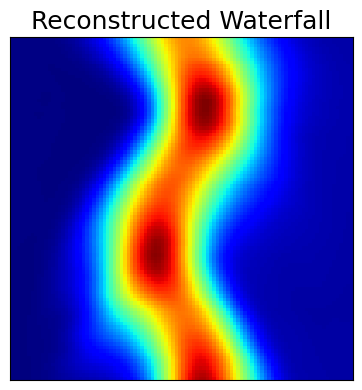

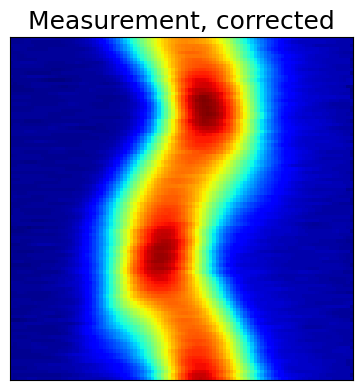

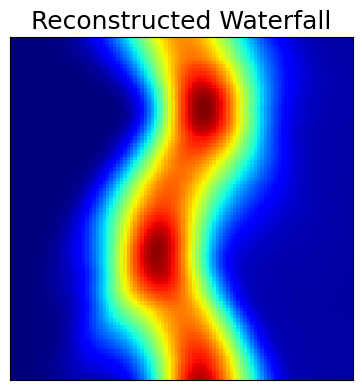

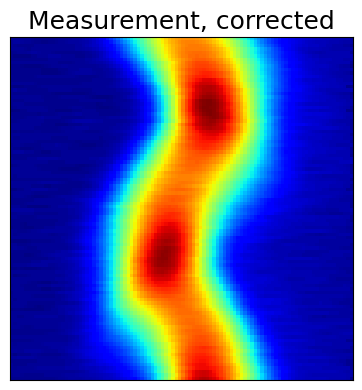

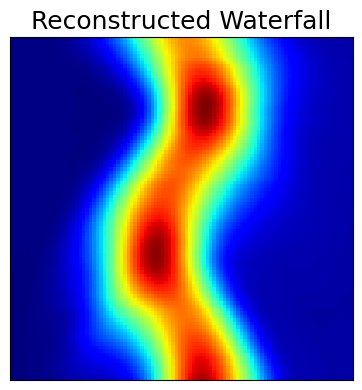

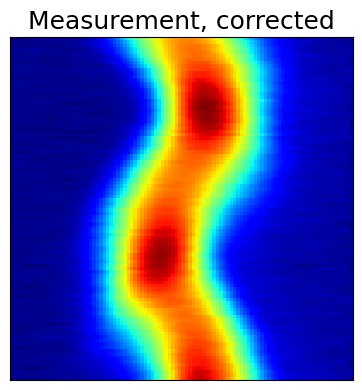

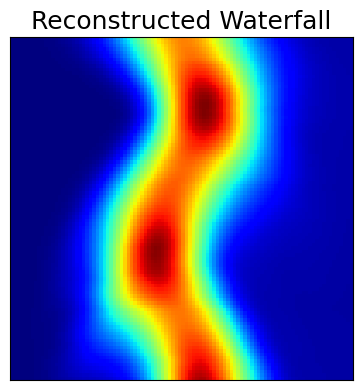

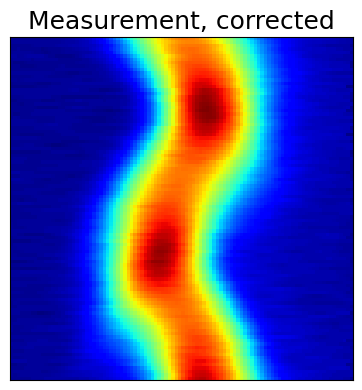

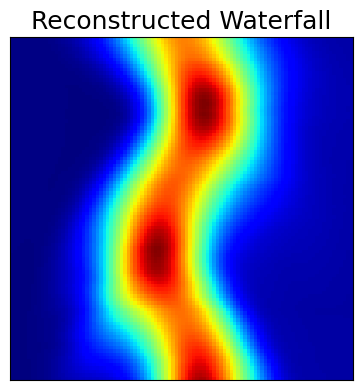

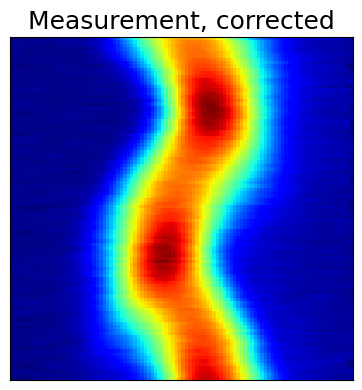

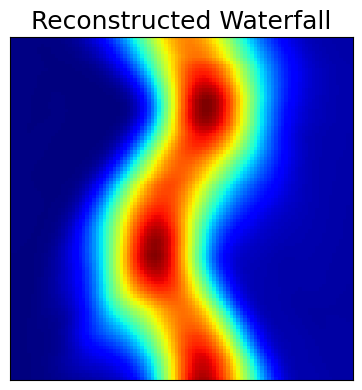

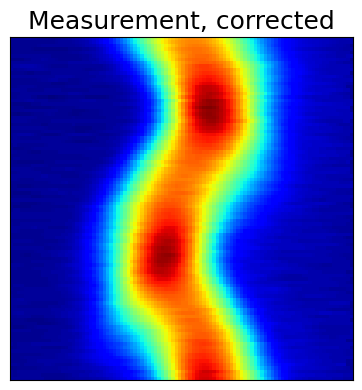

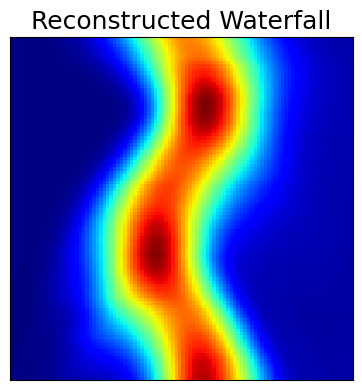

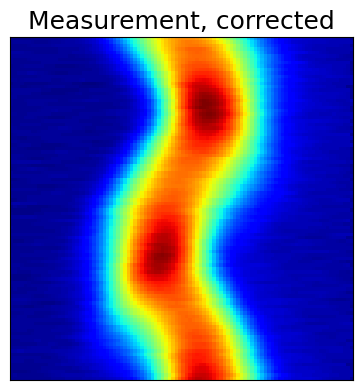

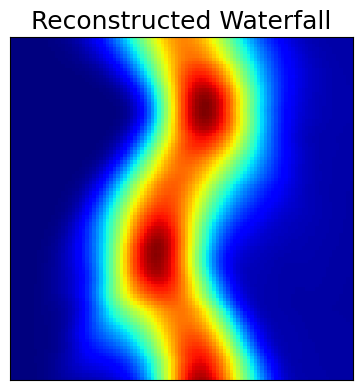

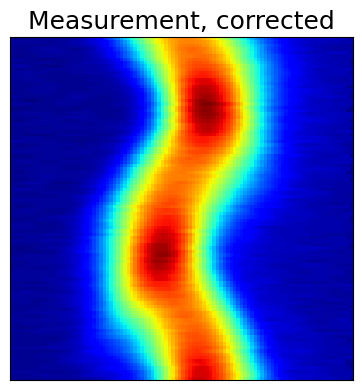

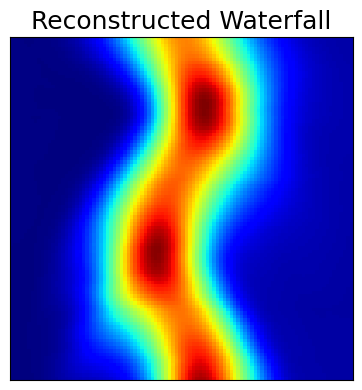

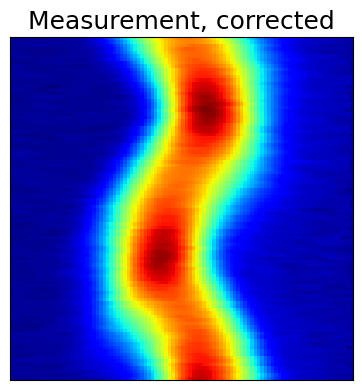

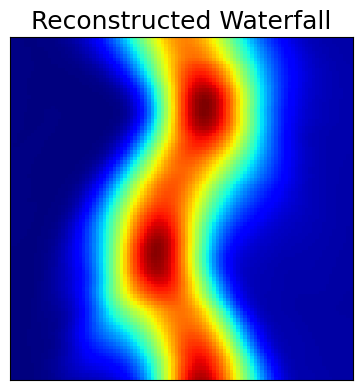

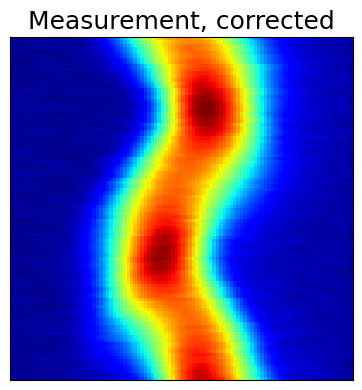

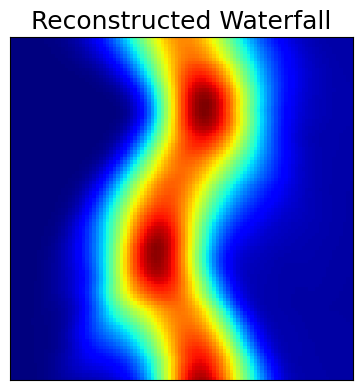

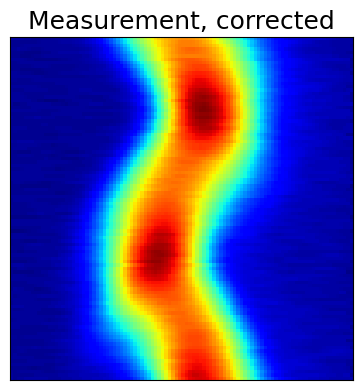

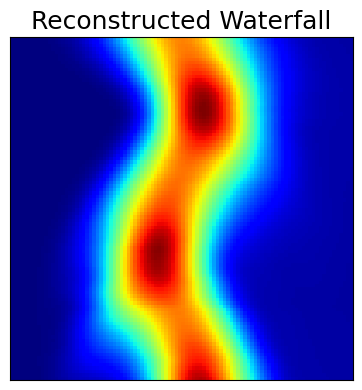

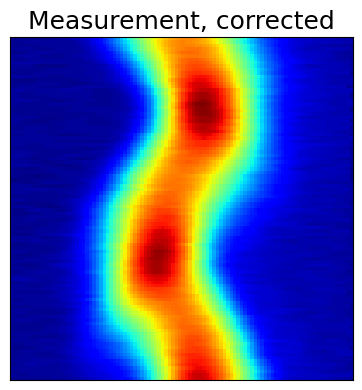

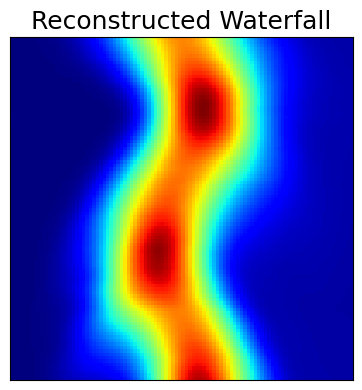

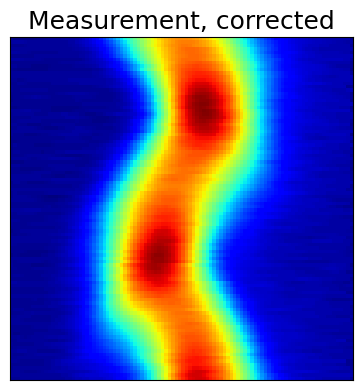

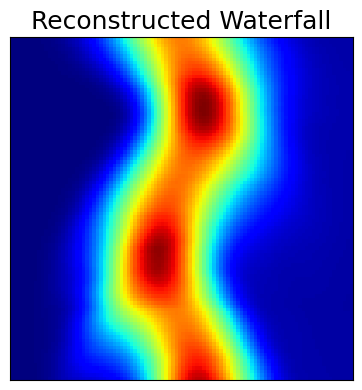

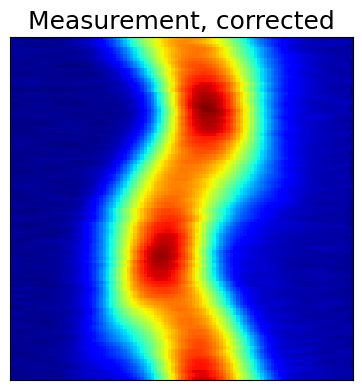

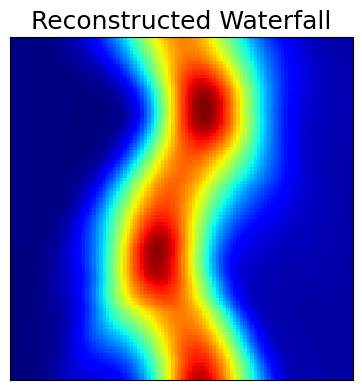

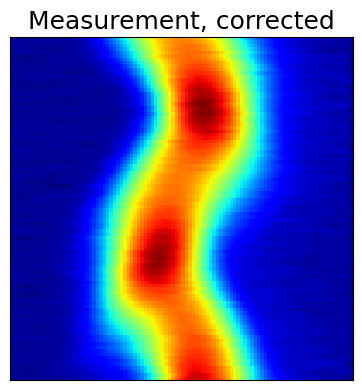

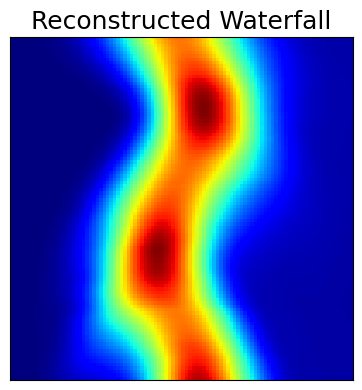

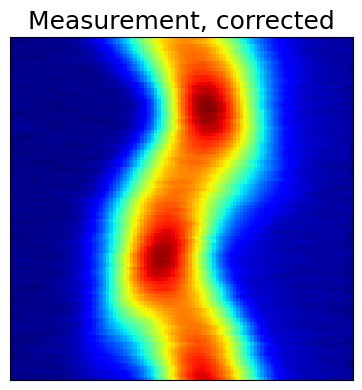

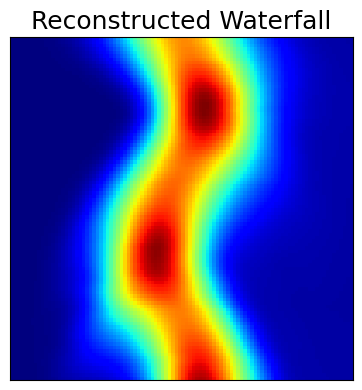

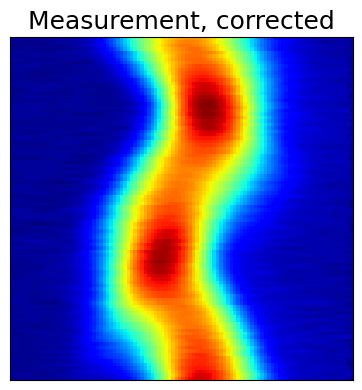

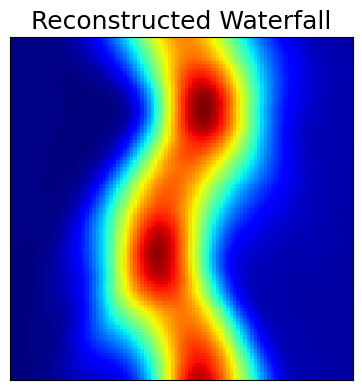

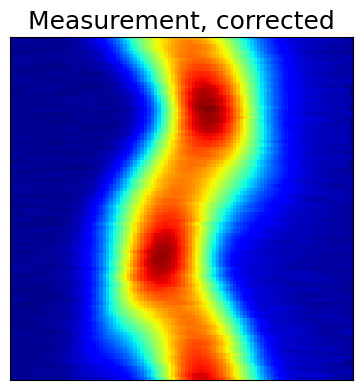

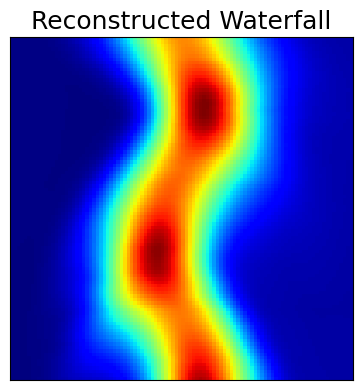

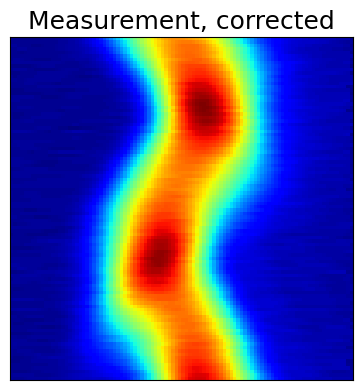

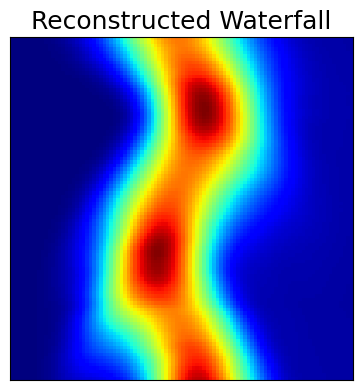

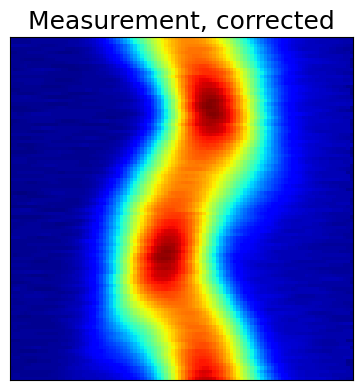

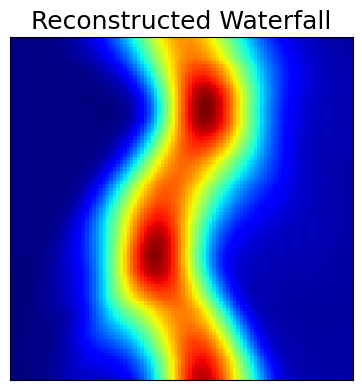

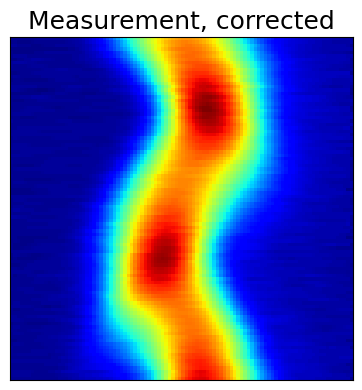

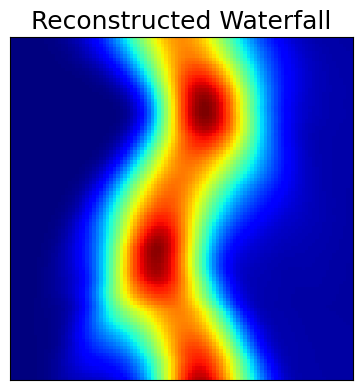

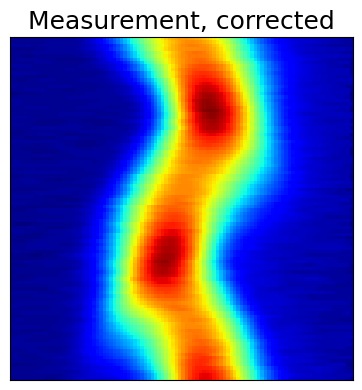

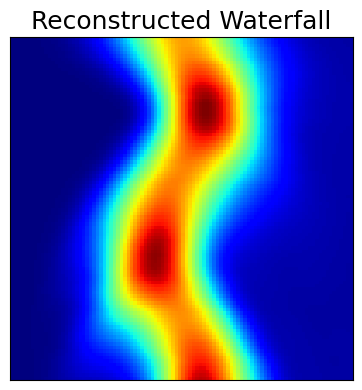

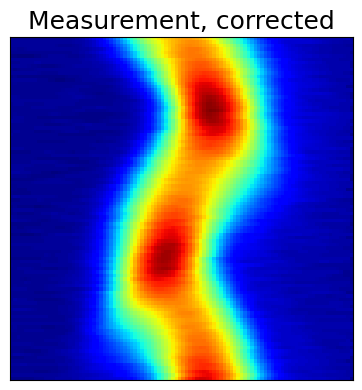

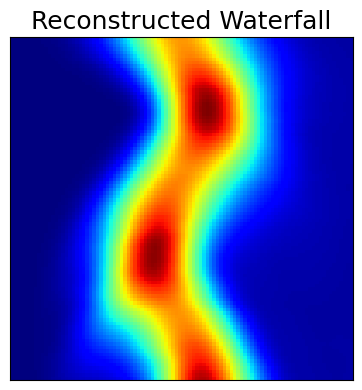

In [20]:

# normalize the turns
# select a number of turns (31)
selected_turns = np.linspace(1, 300, num=100, endpoint=True, dtype=np.float32)
# print(selected_turns)
norm_turns = minmax_normalize_param(selected_turns, np.min(selected_turns),
                                    np.max(selected_turns),
                                    target_range=(0, 1))

# Plot the predicted WF (extracted from the PS) next to the original WF
out_dir = 'plots/real_data_correct_TF_jan2024/predicted_WFs/'
mae_losses = []
for i in np.arange(len(wf_test)):
    # Duplicate the wf_test multiple times
    input_wf = np.tile(wf_test[i], (len(norm_turns), 1, 1, 1))
    latent_pred, ps_pred = encDec.predict(input_wf, norm_turns)
    os.makedirs(out_dir + f'/{wf_id[i]}', exist_ok=True)

    # for idx in np.arange(0, len(ps_pred), 1):
    #     fig = plt.figure(idx, figsize=(3,3))
    #     plt.imshow(ps_pred[idx, 14:-14, 14:-14, 0], cmap='jet')
    #     plt.yticks([], [])
    #     plt.xticks([], [])
    #     plt.tight_layout()
    #     # plt.title(f'PS @ Turn: {idx}')
    #     plt.savefig(os.path.join(out_dir, f'{wf_id[i]}', f'PS_{idx}.png'), transparent=True,
    #                              dpi=200, bbox_inches='tight')

    #     plt.close()
    figname = os.path.join(out_dir, f'{wf_id[i]}', 'reconstruction.png')
    mae_loss = reconstruct_wf(wf_test[i], wf_id[i], bunch_profiles[i], 
                   ps_pred, selected_turns, figname, savefig=False, showfig=False)
    mae_losses.append(mae_loss)
    # break
print('Mean MAE loss: ', np.mean(mae_losses))


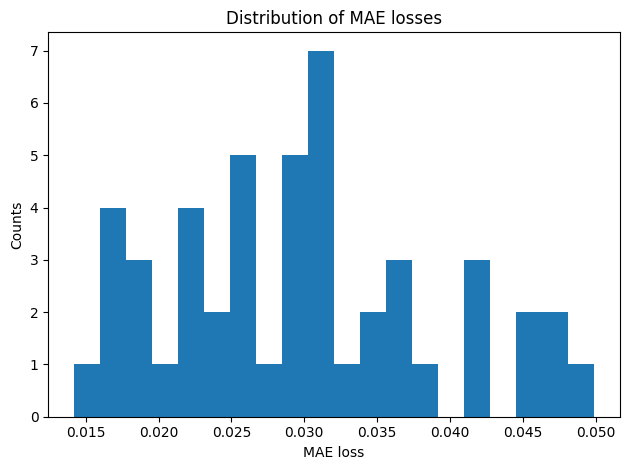

In [21]:
# plot the distribution of the MAE losses
plt.figure()
plt.hist(mae_losses, bins=20)
plt.xlabel('MAE loss')
plt.ylabel('Counts')
plt.title('Distribution of MAE losses')
plt.tight_layout()

## Plot evolution of latent space params per bunch


In [ ]:
# Get latents for all input data
latent_pred = encDec.encode(wf_test, unnormalize=True)

fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(10, 10), sharex=True)
axes = np.ravel(axes, order='F')
# bunch_ids = [name.split(''for name in wf_id]

for lat_id in range(latent_pred.shape[1]):
    y = latent_pred[:, lat_id]
    var_name = var_names[loss_weights[lat_id]]
    ax = axes[lat_id]
    plt.sca(ax)
    if lat_id == 0:
        plt.title('Measurements B2_30660-31130, 2018/09/08')
    plt.ylabel(var_name)
    mean = np.mean(y)
    std = np.std(y)
    plt.plot(y, marker='x', label=f'STD: {std:.2g}')
    plt.axhline(y=mean, label=f'AVG: {mean:.2g}', color='0', ls='--')
    plt.xlabel('Bunch No.')
    plt.legend(loc='upper left')
    # plt.xticks(np.arange(len(y)))
    plt.tight_layout()

fig.delaxes(axes[-1])

plt.savefig('plots/real_data_correct_TF/bunch-by-bunch-variation.png', dpi=300, bbox_inches='tight')
plt.show()
# plt.close()


## Compare real data to simulation data

In [ ]:
from utils import encoder_files_to_tensors, sample_files
# data_dir = './tomo_data/datasets_encoder_TF_16-12-22'
data_dir = './tomo_data/datasets_encoder_TF_03-03-23'

dataset_percent = 1
num_Turns_Case = 1
normalization = 'minmax'
img_normalize = 'off'
ps_normalize = 'off'

# real data: wf_test
real_x = wf_test
real_id = wf_id


In [ ]:
# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TRAINING_PATH = os.path.join(ML_dir, 'TRAINING')
assert os.path.exists(TRAINING_PATH)


# First the training data
file_names = sample_files(
    TRAINING_PATH, dataset_percent, keep_every=num_Turns_Case)
print(len(file_names))
start_t = time.time()
# read input, divide in features/ label, create tensors
sim_x, sim_y = encoder_files_to_tensors(file_names, normalization=normalization,
                                          img_normalize=img_normalize)
sim_x = np.array(sim_x).reshape(-1, 128, 128)
sim_y = np.array(sim_y)
total_time = time.time() - start_t
print(
    f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(file_names):.3f}')


In [ ]:
# Now for every real_x, I need to find a sim_x that is as close as possible
# One metric to use is sum(diff(x1, x2))
min_diff_idx = [-1] * len(real_x)
min_diff_sum = [128 * 128] * len(real_x)

for i in range(len(real_x)):
    for j in range(len(sim_x)):
        diff_sum = np.sum(np.abs(real_x[i][14:-14,14:-14] - sim_x[j][14:-14,14:-14]))
        if diff_sum < min_diff_sum[i]:
            min_diff_sum[i] = diff_sum
            min_diff_idx[i] = j

In [ ]:
# Get the predictions for real and sim data
real_latents = encDec.encode(real_x, unnormalize=True).numpy()
sim_latents = sim_y[min_diff_idx]
sim_latents_unnorm = np.array(unnormalize_params(
        sim_latents[:, 0], sim_latents[:, 1], sim_latents[:, 2],
        sim_latents[:, 3], sim_latents[:, 4], sim_latents[:, 5],
        sim_latents[:, 6], normalization=normalization)).T

In [ ]:
nrows = 5
# Get nrows * nrows random images
sample = np.random.choice(np.arange(len(real_x)),
                          size=nrows, replace=False)

# Create 3x3 grid of figures
fig, axes = plt.subplots(ncols=3, nrows=nrows, figsize=(10, 20), sharex=True)
# axes = np.ravel(axes)
# for i in range(len(axes)):
for i in range(len(sample)):
    ax = axes[i, 0]
    plt.sca(ax)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(real_x[sample[i]], cmap='jet')
    ax.set_title(f'{real_id[sample[i]]}')
    plt.tight_layout()

    ax = axes[i, 1]
    plt.sca(ax)
    plt.tight_layout()

    ax.set_xticks([])
    ax.set_yticks([])
    # show the image
    ax.imshow(sim_x[min_diff_idx[sample[i]]], cmap='jet')
    # title = ','.join([f'{y:.2f}' for y in sim_y[min_diff_idx[sample[i]]]])
    ax.set_title(f'Sim')

    ax = axes[i, 2]
    plt.sca(ax)
    plt.axis('off')

    rowLabels = [var_names[w] for w in loss_weights]
    # cellText = [[latent] for latent in latent_pred_unnorm]
    predicted = real_latents[sample[i]]
    simulated = sim_latents_unnorm[sample[i]]
    cellText = [[f'{predicted[i]:.3g}', f'{simulated[loss_weights[i]]:.3g}'] for i in range(len(predicted))]
    plt.table(cellText=cellText, rowLabels=rowLabels,
              colLabels=['Predicted', 'Simulation'], loc='center')
    plt.tight_layout()
